In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
#from evaluate import f1score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [27]:
#
# Read in and down-select training data
# 

print "Reading and merging orders tables ... ",

train = pd.read_csv('order_products__train.csv')
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

# sample just a subset of training set for speed
N = 5000
oids = train['order_id'].unique()[:N]
train = train[train['order_id'].isin(oids)]
train = train.merge(
    orders, on='order_id', how='left').merge(
    products, on='product_id', how='left')

# take only prior data corresponding to users left in training set
uids = train['user_id'].unique()
prior = prior.merge(orders, on='order_id', how='left')
prior = prior[prior['user_id'].isin(uids)]
prior = prior.merge(products, on='product_id', how='left')

print "done."

 Reading and merging orders tables ...  done.


In [37]:
# Generate np array of features ...
#
# 0th order of business here is to confirm the naive decision 
# tree implemented by hand. 
#

# number of times a product was ordered by user previously
data = prior.groupby(['user_id', 'product_id']
                    ).apply(len).reset_index(name='n_prevly_ordered'
                    ).merge(train, on=['user_id','product_id'], how='left').fillna(0)

In [38]:
data.head(25)

,user_id,product_id,n_prevly_ordered,order_id,add_to_cart_order,reordered,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,30,6184,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,30,21386,5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,30,23288,1,62370.0,1.0,1.0,train,9.0,2.0,13.0,22.0,Distilled Water,115.0,7.0
3,30,27839,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,30,38300,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
5,30,45128,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
6,55,1244,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
7,55,1866,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
8,55,4658,7,39325.0,3.0,1.0,train,8.0,2.0,18.0,30.0,Imported Mineral Water,115.0,7.0
9,55,5194,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [74]:
# input / target
X = np.array([data['n_prevly_ordered'].as_matrix()])
y = data['reordered'].as_matrix()

print X[:25]
print y[:25]

clf = DecisionTreeClassifier(random_state=0, min_samples_split=10000, max_depth=2)
clf.fit(X.T, y)

[[1 5 1 ..., 1 1 1]]
[ 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10000, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [75]:
clf.predict(X.T) - y

array([ 0.,  0., -1., ...,  0.,  0.,  0.])

In [76]:
export_graphviz(clf, out_file='tree.dot')

[  0.           0.51724138   1.03448276   1.55172414   2.06896552
   2.5862069    3.10344828   3.62068966   4.13793103   4.65517241
   5.17241379   5.68965517   6.20689655   6.72413793   7.24137931
   7.75862069   8.27586207   8.79310345   9.31034483   9.82758621
  10.34482759  10.86206897  11.37931034  11.89655172  12.4137931
  12.93103448  13.44827586  13.96551724  14.48275862  15.        ]


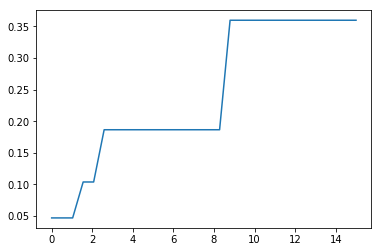

In [82]:
x = np.linspace(0, 15, 30)
print x
y = clf.predict_proba(np.array([x]).T)[:, 1]

%matplotlib inline
import pylab

pylab.plot(x, y)
pylab.show()


In [63]:
#
# Evaluate the model performance on the next 5000 samples
#
#
# Read in and down-select training data
# 

print "Reading and merging orders tables ... ",

train = pd.read_csv('order_products__train.csv')
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

# sample just a subset of training set for speed
N = 5000
oids = train['order_id'].unique()[N:2*N]
train = train[train['order_id'].isin(oids)]
train = train.merge(
    orders, on='order_id', how='left').merge(
    products, on='product_id', how='left')

# take only prior data corresponding to users left in training set
uids = train['user_id'].unique()
prior = prior.merge(orders, on='order_id', how='left')
prior = prior[prior['user_id'].isin(uids)]
prior = prior.merge(products, on='product_id', how='left')

print "done."

Reading and merging orders tables ...  done.


In [ ]:
#
#
# hmmm ... I already know that splitting at p=0.5 is not optimal for the f1 score
# is there a general to understand the split point?
#
# I can't prove it now, but my suspicion is that it's better to guess incorrectly
# (false positive, hurting precision) than to miss out on one ...
#
# --> A true positive helps both precision and recall. A false positive only affects 
# precision.
#
# I think this means in the end, we will have to leave the final split (on probability)
# as a hyperparameter of the model, to be determined after training of the tree.
# But it should probably be less than 0.5.

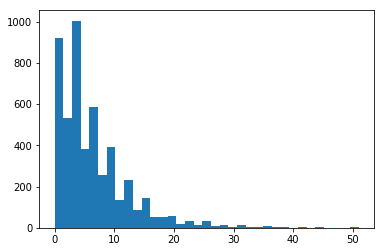

In [84]:
t = train.groupby('order_id').apply(lambda x: sum(x['reordered'])).reset_index(name='n_reordered')
pylab.hist(t['n_reordered'], bins=35)
pylab.show()